In [2]:
# ====================
# データセットの読み込み
# ====================

from sklearn.datasets import load_iris

x, t = load_iris(return_X_y=True)

x.shape, t.shape

((150, 4), (150,))

In [3]:
# ====================
# データの確認
# ====================

import numpy as np
import pandas as pd

pd.DataFrame(np.hstack((x, t.reshape(150, 1))), columns=["x1", "x2", "x3", "x4", "t"])

,x1,x2,x3,x4,t
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


PyTorchで扱うために、データをTensor形式に変換する。

In [4]:
# ====================
# データ形式の変換 (ndarray --> Tensor)
# ====================

import torch

print("変換前：", type(x), type(t))

x = torch.tensor(x, dtype=torch.float32)
t = torch.tensor(t, dtype=torch.int64)

print("変換後：", type(x), type(t))

変換前： <class 'numpy.ndarray'> <class 'numpy.ndarray'>
変換後： <class 'torch.Tensor'> <class 'torch.Tensor'>


PyTorchでは、訓練時に使用するデータ（xとt）を1つのオブジェクト（dataset）にまとめて格納する

In [5]:
# ====================
# データをまとめてデータセットのオブジェクトを構築
# ====================

from torch.utils.data import TensorDataset

dataset = TensorDataset(x, t)

print("最初のサンプル：", dataset[0])
print("最初のサンプルの特徴ベクトル：", dataset[0][0])
print("最初のサンプルの目標値：", dataset[0][1])

print("最後のサンプル：", dataset[-1])
print("最後のサンプルの特徴ベクトル：", dataset[-1][0])
print("最後のサンプルの目標値：", dataset[-1][1])

最初のサンプル： (tensor([5.1000, 3.5000, 1.4000, 0.2000]), tensor(0))
最初のサンプルの特徴ベクトル： tensor([5.1000, 3.5000, 1.4000, 0.2000])
最初のサンプルの目標値： tensor(0)
最後のサンプル： (tensor([5.9000, 3.0000, 5.1000, 1.8000]), tensor(2))
最後のサンプルの特徴ベクトル： tensor([5.9000, 3.0000, 5.1000, 1.8000])
最後のサンプルの目標値： tensor(2)


データセットを、訓練用（training）・検証用（validation）・評価用（test）に分割する。

深層学習では、充分多くのデータを扱えることが前提のため、交差検証をする代わりにハイパラ調整のための検証用データを切り分ける。


In [6]:
# ====================
# 訓練用・検証用・評価用に6:2:2で分割
# ====================

from torch.utils.data import random_split

n_train = int(len(dataset) * 0.6)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val

# ランダムに分割するので、再現性の確保のためにランダムシードを固定
torch.manual_seed(42)
train, val, test = random_split(dataset, [n_train, n_val, n_test])

len(train), len(val), len(test)

(90, 30, 30)

DataLoader を用いてデータセットからバッチサイズ分のサンプルを取得し、ミニバッチ学習を行う。

ミニバッチ学習では、訓練データのみシャッフルしながらサンプルを抽出する。

In [7]:
# ====================
# 訓練用・検証用・評価用の各データをDataLoaderに格納
# ====================

from torch.utils.data import DataLoader

batch_size = 10

train_loader = DataLoader(train, batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size)
test_loader = DataLoader(test, batch_size)

# 2. ネットワークの定義

今回は、特徴量が4種類、クラス数が3種類なので、4次元1層の中間層を持つMLPを用いることにする。

PyTorchでは、ネットワークの記述にクラスを使う。

全結合層などパラメタを含んだ層を `__init__()` メソッド内に定義し、順伝播の計算を `forward()` メソッド内に記述する。

In [8]:
# ====================
# MLPを定義
# ====================

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # 使用するオブジェクトを定義
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)  # 4層の入力層から4層の中間層への全結合
        self.fc2 = nn.Linear(4, 3)  # 4層の中間層から3層の出力層への全結合
    
    # 順伝播
    def forward(self, x):
        h = F.relu(self.fc1(x))  # xを線形変換（fc1）し、非線形変換（relu）し、中間表現hを得る
        y = self.fc2(h)  # 中間表現hを線形変換（fc2）し、出力yを得る
        return y

# ネットワークのインスタンスを作成
net = Net()

# 3. 損失関数の選択

今回は分類問題を扱うので、損失関数としてクロスエントロピーを採用する。

PyTorchでは、損失関数を `criterion` という名前で定義するのが慣習である。

In [9]:
criterion = nn.CrossEntropyLoss()

# 4. 最適化手法の選択

パラメタ更新に用いる最適化手法を選ぶ。

PyTorchでは、最適化手法を `optimizer` という名前で定義するのが慣習である。

今回は、基本的な最適化手法である確率的勾配降下法（SGD）を採用する。

Optimizerの引数には、ネットワークのパラメタと学習率を設定する。

In [10]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# 5. ネットワークの学習

深層学習では、GPUによる高速演算を利用するのが一般的である。

GPUを使う際には、訓練時にモデルとデータの両方をGPUのメモリ上に転送する必要がある。

In [11]:
# ====================
# モデルをGPUへ転送
# ====================

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)

device

device(type='cuda', index=0)

In [12]:
# ====================
# 正解率の計算（検証セット評価セット用）
# ====================

def calc_acc(data_loader):

    with torch.no_grad():
        accs = list()
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = net(x)

            label = torch.argmax(y, dim=1)
            acc = (label == t).sum() * 1.0 / len(t)
            accs.append(acc)

    return torch.tensor(accs).mean()

In [ ]:
# ====================
# 訓練ループ
# ====================

max_epoch = 30

for epoch in range(max_epoch):

    # ミニバッチ学習
    for batch in train_loader:

        # バッチサイズ分のサンプルを抽出
        x, t = batch  # 1

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)  # 2
        loss = criterion(y, t)  # 3

        # 学習状況の確認
        label = torch.argmax(y, dim=1)
        acc = (label == t).sum() * 1.0 / len(t)
        print("epoch: %d    loss: %.3f    acc: %.3f" % (epoch+1, loss.item(), acc))

        # 誤差逆伝播
        loss.backward()  # 4
        optimizer.step()  # 5
    
    # 検証データの性能を確認
    val_acc = calc_acc(val_loader)
    print("epoch: %d    val_acc: %.3f" % (epoch+1, val_acc))

In [14]:
# ====================
# 評価用データで性能確認
# ====================

test_acc = calc_acc(test_loader)
test_acc

tensor(0.5000)

<AxesSubplot:>

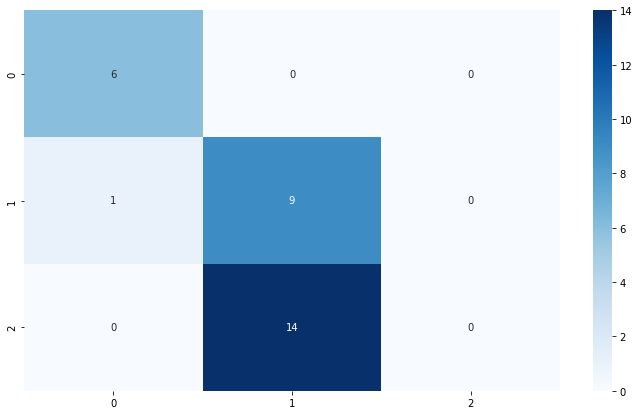

In [19]:
#
# confusion_matrix
#

nb_classes = 3
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for batch in test_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        y = net(x)

        label = torch.argmax(y, dim=1)
        for t_conf, p in zip(t.view(-1), label.view(-1)):
            confusion_matrix[t_conf.long(), p.long()] += 1

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


confusion_matrix_numpy = confusion_matrix.to('cpu').detach().numpy().copy()
df_cmx = pd.DataFrame(confusion_matrix_numpy)
plt.figure(figsize= (12,7))
sn.heatmap(df_cmx, annot=True, fmt='g', cmap='Blues')